In [110]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from sklearn.model_selection import train_test_split
from random import randint, random

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [3]:
image_size = (208,208)
batch_size = 32

In [4]:
def correct_data_car(image_size, df = None):
    boxes = []
    a,b = image_size
    if df is None:
        df = pd.read_csv('_annotations.csv') 
    for height, width, x1, y1, x2, y2 in zip(df['height'], df['width'], list(df['xmin'].apply(lambda x: int(x) / 416 * a)), list(df['ymin'].apply(lambda x: int(x) / 416 * a)), 
               list(df['xmax'].apply(lambda x: int(x) / 416 * a)), list(df['ymax'].apply(lambda x: int(x) / 416 * a))):
        if height == 0 and width ==0:
            boxes.append([0,0,0,0])
        else:
            arr = [int(x1), int(y1), int(x2), int(y2)]
            boxes.append(arr)
    return df, boxes

In [5]:
def correct_data_accidents(image_size, df = None):
    boxes = []
    a,b = image_size
    if df is None:
        df = pd.read_csv('accidents.csv') 
    for x1,y1,x2,y2 in zip(list(df['xmin'].apply(lambda x: int(x) * (a / 1280))), list(df['ymin'].apply(lambda x: int(x) * (b / 720))), 
                           list(df['xmax'].apply(lambda x: int(x) * (a / 1280))), list(df['ymax'].apply(lambda x: int(x) * (b / 720)))):
        arr = [int(x1), int(y1), int(x2), int(y2)]
        boxes.append(arr)
    return df, boxes

In [48]:
def data_metrics(df,image_size):
    images = []
    for index, i in df.iterrows():
        image = cv2.imread(index)
        image = cv2.resize(image,image_size)
        images.append(image)
    return images

In [7]:
def classification(df):
    train_class = []
    for index, row in df.iterrows():
        if row['class'] == 'vehicle' or row['class'] == 'motorbike':
            train_class.append([0,1])
        elif row['class'] =='accidents':
            train_class.append([1,0])
        else: 
            train_class.append([0,0])
    return np.array(train_class)

In [8]:
def data_img(images, coordinates, image_size):
    scarled_region_class = []
    scarled_region_loc = []
    a,b = image_size
    for image, coords in zip(images, coordinates):
        x, y, w, h = coords
        if x + y + w + h != 0:
            car_region = image[y:h, x:w]
            scarled_region_class.append(cv2.resize(car_region, image_size))
            scarled_region_loc.append(cv2.resize(image, image_size))
        else:
            scarled_region_class.append(cv2.resize(image, image_size))
            scarled_region_loc.append(cv2.resize(image, image_size))
    return np.array(scarled_region_loc), np.array(coordinates),np.array(scarled_region_class)

# ненужное комментить!!!!

In [69]:
# ##Для классификации машин
# df_trash = pd.DataFrame({'filename': os.listdir('DataSet_cars_valid\\1_trash')})
# df_trash = df_trash.set_index('filename')
# df_trash = df_trash.astype(str)

In [105]:
##Аварии
%cd data/train/Accident
df_accidents, boxes_accidents = correct_data_accidents(image_size)
df_accidents = df_accidents.set_index('filename')
del df_accidents['Unnamed: 0']
df_accidents = df_accidents.astype(str)
image_acc = data_metrics(df_accidents,image_size)
%cd ../../..

C:\Users\Matvey\Проект\Project\data\train\Accident
C:\Users\Matvey\Проект\Project


In [102]:
# ##Классификация только машин
# %cd DataSet_cars_valid/valid_test
# df_car, boxes_car = correct_data_car(image_size)
# train = df_car.set_index('filename')
# train = train.astype(str)
# train = pd.concat([train, df_trash])
# train = train.fillna(0)
# train, boxes_train = correct_data_car(image_size, train)
# image_train = data_metrics(train,image_size)
# %cd ../..

C:\Users\Matvey\Проект\Project\DataSet_cars_valid\valid_test
C:\Users\Matvey\Проект\Project


In [111]:
##классификация с авариями
%cd DataSet_cars_valid/val
df_car, boxes_car = correct_data_car(image_size)
train = df_car.set_index('filename')
train = pd.concat([train,df_accidents])
boxes_train = boxes_car + boxes_accidents
image_train = data_metrics(train,image_size)
%cd ../..

[WinError 3] Системе не удается найти указанный путь: 'DataSet_cars_valid/val'
C:\Users\Matvey\Проект\Project\DataSet_cars_valid\val
C:\Users\Matvey\Проект\Project


In [98]:
# ##локализация 
# %cd DataSet_cars_valid/valid
# df_car, boxes_train = correct_data_car(image_size)
# train = df_car.set_index('filename')
# train = train.sort_values(by = 'filename')
# image_train = data_metrics(train,image_size)
# %cd ../..

C:\Users\Matvey\Проект\Project\DataSet_cars_valid\valid
C:\Users\Matvey\Проект\Project


In [112]:
region_train, image_coodrs, scarled_region = data_img(image_train, boxes_train, image_size)

In [93]:
#проверка
len(region_train)

2619

In [32]:
class_train = classification(train)

In [113]:
for i, image in enumerate(region_train):
    if i % 100 == 0: print(i)
    x, y, w, h = image_coodrs[i]
    if x+y+w+h != 0:
        cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

0
100
200
300


KeyboardInterrupt: 

In [62]:
#попробовал уже пред. обученную модель, получилось хуже)
# #Загрузить модель NasNetMobile, обязательно исключив вершину для трансферного обучения
# N_mobile = tf.keras.applications.NASNetMobile( input_tensor = Input(
#     shape=(208,208,3)), 
#     include_top=False, 
#     weights='imagenet')

In [30]:
def create_model_loc():
    model = keras.Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(208, 208, 3)),  # свёрточный слой 
    #попробуй по 2-3 свёрточных слоя сделать
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(128, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(512, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов    
        
    Flatten(),
    Dense(512, activation='relu'),  # обычные нейроны Dense(512)
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(256, activation='relu'),  # обычные нейроны Dense(256)
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(128, activation='relu'),  # обычные нейроны Dense(128)
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(4, activation='linear')  # выходной слой 
])
    return model

model_loc = create_model_loc()
model_loc.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [39]:
def create_model_class():
    model = keras.Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(208, 208, 3)),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(128, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(512, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Flatten(),
    Dense(512, activation='relu'),  # обычные нейроны 
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(256, activation='relu'),  # обычные нейроны 
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(128, activation='relu'),  # обычные нейроны
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(2, activation='sigmoid'),  # выходной слой
    ])
    return model
model_class = create_model_class()
model_class.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
train_data, val_data, train_coords, val_coords,train_class, val_class, train_region, val_region = train_test_split(
    region_train, image_coodrs, class_train,scarled_region, test_size=0.2, random_state=42)

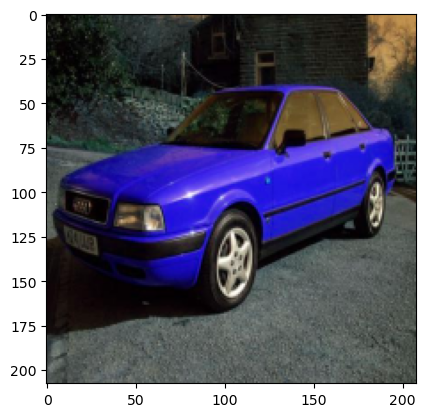

In [35]:
test = tf.convert_to_tensor(train_data[1])
plt.imshow(test, cmap='gray')
plt.show()

In [27]:
# train_class = np.array(train_class)
# val_class = np.array(val_class)

In [40]:
#классификация
#history = model_class.fit(train_region, train_class, epochs = 60, batch_size = batch_size, validation_data = (val_region, val_class))
#локализация
history = model_loc.fit(train_data, train_coords, epochs = 500, batch_size = 32, validation_data = (val_data, val_coords))

Epoch 1/500
66/66 [==============================] - 7s 99ms/step - loss: 737.2552 - mse: 737.2552 - val_loss: 916.3078 - val_mse: 916.3078
Epoch 2/500
66/66 [==============================] - 6s 98ms/step - loss: 733.3640 - mse: 733.3640 - val_loss: 952.3298 - val_mse: 952.3298
Epoch 3/500
66/66 [==============================] - 7s 99ms/step - loss: 723.7487 - mse: 723.7487 - val_loss: 1203.3345 - val_mse: 1203.3345
Epoch 4/500
66/66 [==============================] - 7s 99ms/step - loss: 732.8285 - mse: 732.8285 - val_loss: 1087.4852 - val_mse: 1087.4852
Epoch 5/500
66/66 [==============================] - 7s 99ms/step - loss: 727.2195 - mse: 727.2195 - val_loss: 1239.8199 - val_mse: 1239.8199
Epoch 6/500
66/66 [==============================] - 7s 99ms/step - loss: 725.4504 - mse: 725.4504 - val_loss: 977.1509 - val_mse: 977.1509
Epoch 7/500
66/66 [==============================] - 7s 99ms/step - loss: 727.1071 - mse: 727.1071 - val_loss: 1071.2075 - val_mse: 1071.2075
Epoch 8/500


66/66 [==============================] - 7s 107ms/step - loss: 700.0029 - mse: 700.0029 - val_loss: 637.8569 - val_mse: 637.8569
Epoch 116/500
66/66 [==============================] - 10s 151ms/step - loss: 715.1524 - mse: 715.1524 - val_loss: 626.2531 - val_mse: 626.2531
Epoch 117/500
66/66 [==============================] - 7s 107ms/step - loss: 697.1282 - mse: 697.1282 - val_loss: 611.0321 - val_mse: 611.0321
Epoch 118/500
66/66 [==============================] - 7s 107ms/step - loss: 702.5177 - mse: 702.5177 - val_loss: 649.5685 - val_mse: 649.5685
Epoch 119/500
66/66 [==============================] - 7s 107ms/step - loss: 707.5212 - mse: 707.5212 - val_loss: 618.1341 - val_mse: 618.1341
Epoch 120/500
66/66 [==============================] - 7s 107ms/step - loss: 690.0194 - mse: 690.0194 - val_loss: 618.3717 - val_mse: 618.3717
Epoch 121/500
66/66 [==============================] - 7s 107ms/step - loss: 697.8558 - mse: 697.8558 - val_loss: 611.6578 - val_mse: 611.6578
Epoch 122/50

66/66 [==============================] - 7s 113ms/step - loss: 686.6009 - mse: 686.6009 - val_loss: 596.7732 - val_mse: 596.7732
Epoch 230/500
66/66 [==============================] - 8s 115ms/step - loss: 694.8920 - mse: 694.8920 - val_loss: 600.0299 - val_mse: 600.0299
Epoch 231/500
66/66 [==============================] - 8s 115ms/step - loss: 694.2747 - mse: 694.2747 - val_loss: 597.9716 - val_mse: 597.9716
Epoch 232/500
66/66 [==============================] - 8s 115ms/step - loss: 684.7744 - mse: 684.7744 - val_loss: 601.2248 - val_mse: 601.2248
Epoch 233/500
66/66 [==============================] - 8s 114ms/step - loss: 678.3367 - mse: 678.3367 - val_loss: 596.1208 - val_mse: 596.1208
Epoch 234/500
66/66 [==============================] - 7s 113ms/step - loss: 689.8322 - mse: 689.8322 - val_loss: 596.9206 - val_mse: 596.9206
Epoch 235/500
66/66 [==============================] - 7s 113ms/step - loss: 693.4450 - mse: 693.4450 - val_loss: 598.8021 - val_mse: 598.8021
Epoch 236/500

66/66 [==============================] - 7s 110ms/step - loss: 692.0936 - mse: 692.0936 - val_loss: 597.1248 - val_mse: 597.1248
Epoch 344/500
66/66 [==============================] - 7s 109ms/step - loss: 691.9094 - mse: 691.9094 - val_loss: 597.2880 - val_mse: 597.2880
Epoch 345/500
66/66 [==============================] - 7s 109ms/step - loss: 686.4561 - mse: 686.4561 - val_loss: 596.7805 - val_mse: 596.7805
Epoch 346/500
66/66 [==============================] - 7s 109ms/step - loss: 692.1739 - mse: 692.1739 - val_loss: 599.6385 - val_mse: 599.6385
Epoch 347/500
66/66 [==============================] - 7s 109ms/step - loss: 693.5897 - mse: 693.5897 - val_loss: 596.6363 - val_mse: 596.6363
Epoch 348/500
66/66 [==============================] - 7s 109ms/step - loss: 696.8079 - mse: 696.8079 - val_loss: 601.1848 - val_mse: 601.1848
Epoch 349/500
66/66 [==============================] - 9s 131ms/step - loss: 681.4477 - mse: 681.4477 - val_loss: 597.9443 - val_mse: 597.9443
Epoch 350/500

66/66 [==============================] - 7s 107ms/step - loss: 690.2815 - mse: 690.2815 - val_loss: 596.7502 - val_mse: 596.7502
Epoch 458/500
66/66 [==============================] - 7s 107ms/step - loss: 693.9257 - mse: 693.9257 - val_loss: 596.3574 - val_mse: 596.3574
Epoch 459/500
66/66 [==============================] - 7s 107ms/step - loss: 690.1296 - mse: 690.1296 - val_loss: 600.4181 - val_mse: 600.4181
Epoch 460/500
66/66 [==============================] - 7s 107ms/step - loss: 674.0663 - mse: 674.0663 - val_loss: 595.9285 - val_mse: 595.9285
Epoch 461/500
66/66 [==============================] - 7s 106ms/step - loss: 687.7599 - mse: 687.7599 - val_loss: 597.6213 - val_mse: 597.6213
Epoch 462/500
66/66 [==============================] - 7s 107ms/step - loss: 689.1594 - mse: 689.1594 - val_loss: 600.9144 - val_mse: 600.9144
Epoch 463/500
66/66 [==============================] - 7s 107ms/step - loss: 688.5292 - mse: 688.5292 - val_loss: 597.4924 - val_mse: 597.4924
Epoch 464/500

In [42]:
model_loc.save('Модели на тест\\loc_new_test.h5')

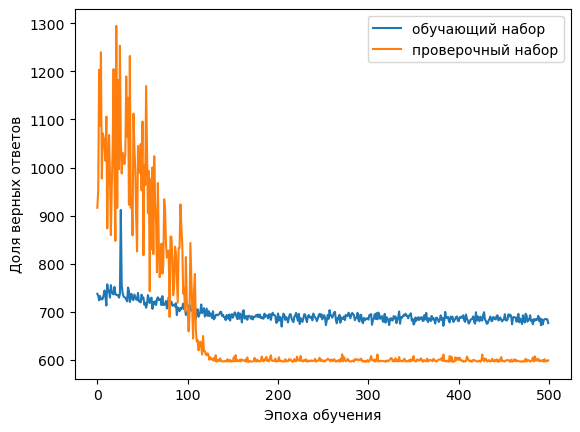

In [41]:
plt.plot(history.history['mse'],
         label='обучающий набор')
plt.plot(history.history['val_mse'],
         label='проверочный набор')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
